# **Prueba técnica Cielum | Analytics leader**

## Cesar Ramirez Gomez
### Ingeniero electronico
### Estudiante maestria en inteligencia artificial

---
###Modelos de inteligencia artificial 


In [ ]:
from datetime import datetime, timedelta, date
import numpy as np
import pandas as pd
from collections import Counter
from pylab import rcParams
import statsmodels.api as sm
import multiprocessing
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline  

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold, ParameterGrid
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from termcolor import colored
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import scipy.stats as stats
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import zscore
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
pd.set_option('display.max_columns',29)

In [ ]:
#Leyendo el archivo con los datos y conversion a DataFrame
datos = pd.read_excel("/content/drive/MyDrive/Colab_Notebooks/prueba/datos_limpios.xlsx")
df = pd.DataFrame(datos)

# Division conjunto de datos en entrenamiento y prueba

In [ ]:
#Se selecciona aleatoriamente 500 elementos de la variable mayoritaria
from sklearn.utils import resample
exito = df[df["Variable_objetivo"]== 1]
fracaso = df[df["Variable_objetivo"]== 0]
fracaso_reduccion = resample(fracaso, replace=True, n_samples=500, random_state=42)
dataset_disminuido = pd.concat([fracaso_reduccion,exito])

In [ ]:
#Se define la variable objetivo, se divide el set de datos en entrenamiento (80%) y prueba (20%) con una semilla aleatoria de 42 
labels = dataset_disminuido.Variable_objetivo
features = dataset_disminuido.drop(['Variable_objetivo'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42)

In [ ]:
#Se escala las variables con el mismo peso y se obtiene el numero de datos para entrenamiento y prueba
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
print('Tamaño variables entrenamiento:', X_train.shape)
print('Tamaño etiquetas entrenamiento:', y_train.shape)
print('Tamaño variables testeo:', X_test.shape)
print('Tamaño etiquetas testeo:', y_test.shape)

Tamaño variables entrenamiento: (417, 73)
Tamaño etiquetas entrenamiento: (417,)
Tamaño variables testeo: (105, 73)
Tamaño etiquetas testeo: (105,)


# BALANCEDO DE DATOS

Se aplican tecnicas de balanceo con la libreria SMOTE, que permite el sobremuestreo de minorías sintéticas aumentando el número de casos de un conjunto de datos de forma equilibrada. Se genera nuevas instancias a partir de casos minoritarios existentes.

In [ ]:
from imblearn.combine import SMOTEENN
counter = Counter(y_train)
print("Antes de balanceo de datos: ", counter)
smenn = SMOTEENN()
X_train_smenn, y_train_smenn = smenn.fit_resample(X_train, y_train)
counter2 = Counter(y_train_smenn)
print("Despues de balanceo de datos: ", counter2)

Antes de balanceo de datos:  Counter({0: 404, 1: 13})
Despues de balanceo de datos:  Counter({1: 404, 0: 387})


In [ ]:
#Funcion para generar la matriz de confusion
def draw_cm(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = [0,1] , yticklabels = [0,1] )
    plt.ylabel('Observed')
    plt.xlabel('Predicted')
    plt.show()

Random forest


In [ ]:
# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20],
                 'criterion'   : ['gini', 'entropy']
                }
            )

# Loop paralelizado para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
def eval_oob_error(X, y, modelo, params, verbose=True):
    """
    Función para entrenar un modelo utilizando unos parámetros determinados
    y que devuelve el out-of-bag error
    """
    modelo.set_params(
        oob_score    = True,
        n_jobs       = -1,
        random_state = 123,
        ** params            
    )
    
    modelo.fit(X, y)
    
    if verbose:
        print(f"Modelo: {params} \u2713")
        
    return{'params': params, 'oob_accuracy': modelo.oob_score_}


n_jobs     = multiprocessing.cpu_count() -1
pool       = multiprocessing.Pool(processes=n_jobs)
resultados = pool.starmap(
                eval_oob_error,
                [(X_train_smenn, y_train_smenn, RandomForestClassifier(), params) for params in param_grid]
             )

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados.head(4)

Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterio

,oob_accuracy,criterion,max_depth,max_features,n_estimators
0,1.0,gini,NaN,5,150
11,1.0,gini,20.0,9,150
22,1.0,entropy,20.0,7,150
21,1.0,entropy,20.0,5,150


In [ ]:
rf = RandomForestClassifier(n_estimators = 150, max_depth = None, max_features = 5, bootstrap = True, random_state = 18)
rf.fit(X_train_smenn, y_train_smenn)

RandomForestClassifier(max_features=5, n_estimators=150, random_state=18)

In [ ]:
y_predict = rf.predict(X_test)

Accuracy entrenamiento 1.0
Accuracy testeo 0.9904761904761905
Recall:  1.0
Precisión:  0.9
F1 Score:  0.9473684210526316
Roc Auc Score:  0.9947916666666667
Matriz de confusión


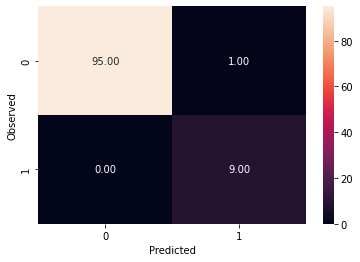

None


In [ ]:
print("Accuracy entrenamiento", rf.score(X_train,y_train))  
print("Accuracy testeo",rf.score(X_test, y_test))
print("Recall: ", recall_score(y_test,y_predict))
print("Precisión: ", precision_score(y_test,y_predict))
print("F1 Score: ", f1_score(y_test,y_predict))
print("Roc Auc Score: ", roc_auc_score(y_test,y_predict))
print('Matriz de confusión')
print(draw_cm(y_test,y_predict))

# **REGRESION LINEA**

In [ ]:
def lr_grid_search(X, y):
    model = LogisticRegression()
    
    # Create a dictionary of all values we want to test
    solvers = ['newton-cg', 'lbfgs', 'liblinear']
    penalty = ['l2']
    c_values = [100, 10, 1.0, 0.1, 0.01]
    
    # define grid search
    param_grid = dict(solver=solvers, penalty=penalty, C=c_values)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='accuracy')
    grid_result = grid_search.fit(X, y)
    
    return grid_result.best_params_


In [ ]:
lr_grid_search(X_train_smenn, y_train_smenn)

{'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}

In [ ]:
lr =LogisticRegression(C=1.0, penalty='l2', solver='newton-cg')
lr.fit(X_train_smenn, y_train_smenn)
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

print(lr.score(X_train_smenn, y_train_smenn))
print(lr.score(X_train_smenn, y_train_smenn))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96        96
           1       0.57      0.89      0.70         9

    accuracy                           0.93       105
   macro avg       0.78      0.91      0.83       105
weighted avg       0.95      0.93      0.94       105

Accuracy: 0.9333333333333333
Precision: 0.5714285714285714
Recall: 0.8888888888888888
1.0
1.0


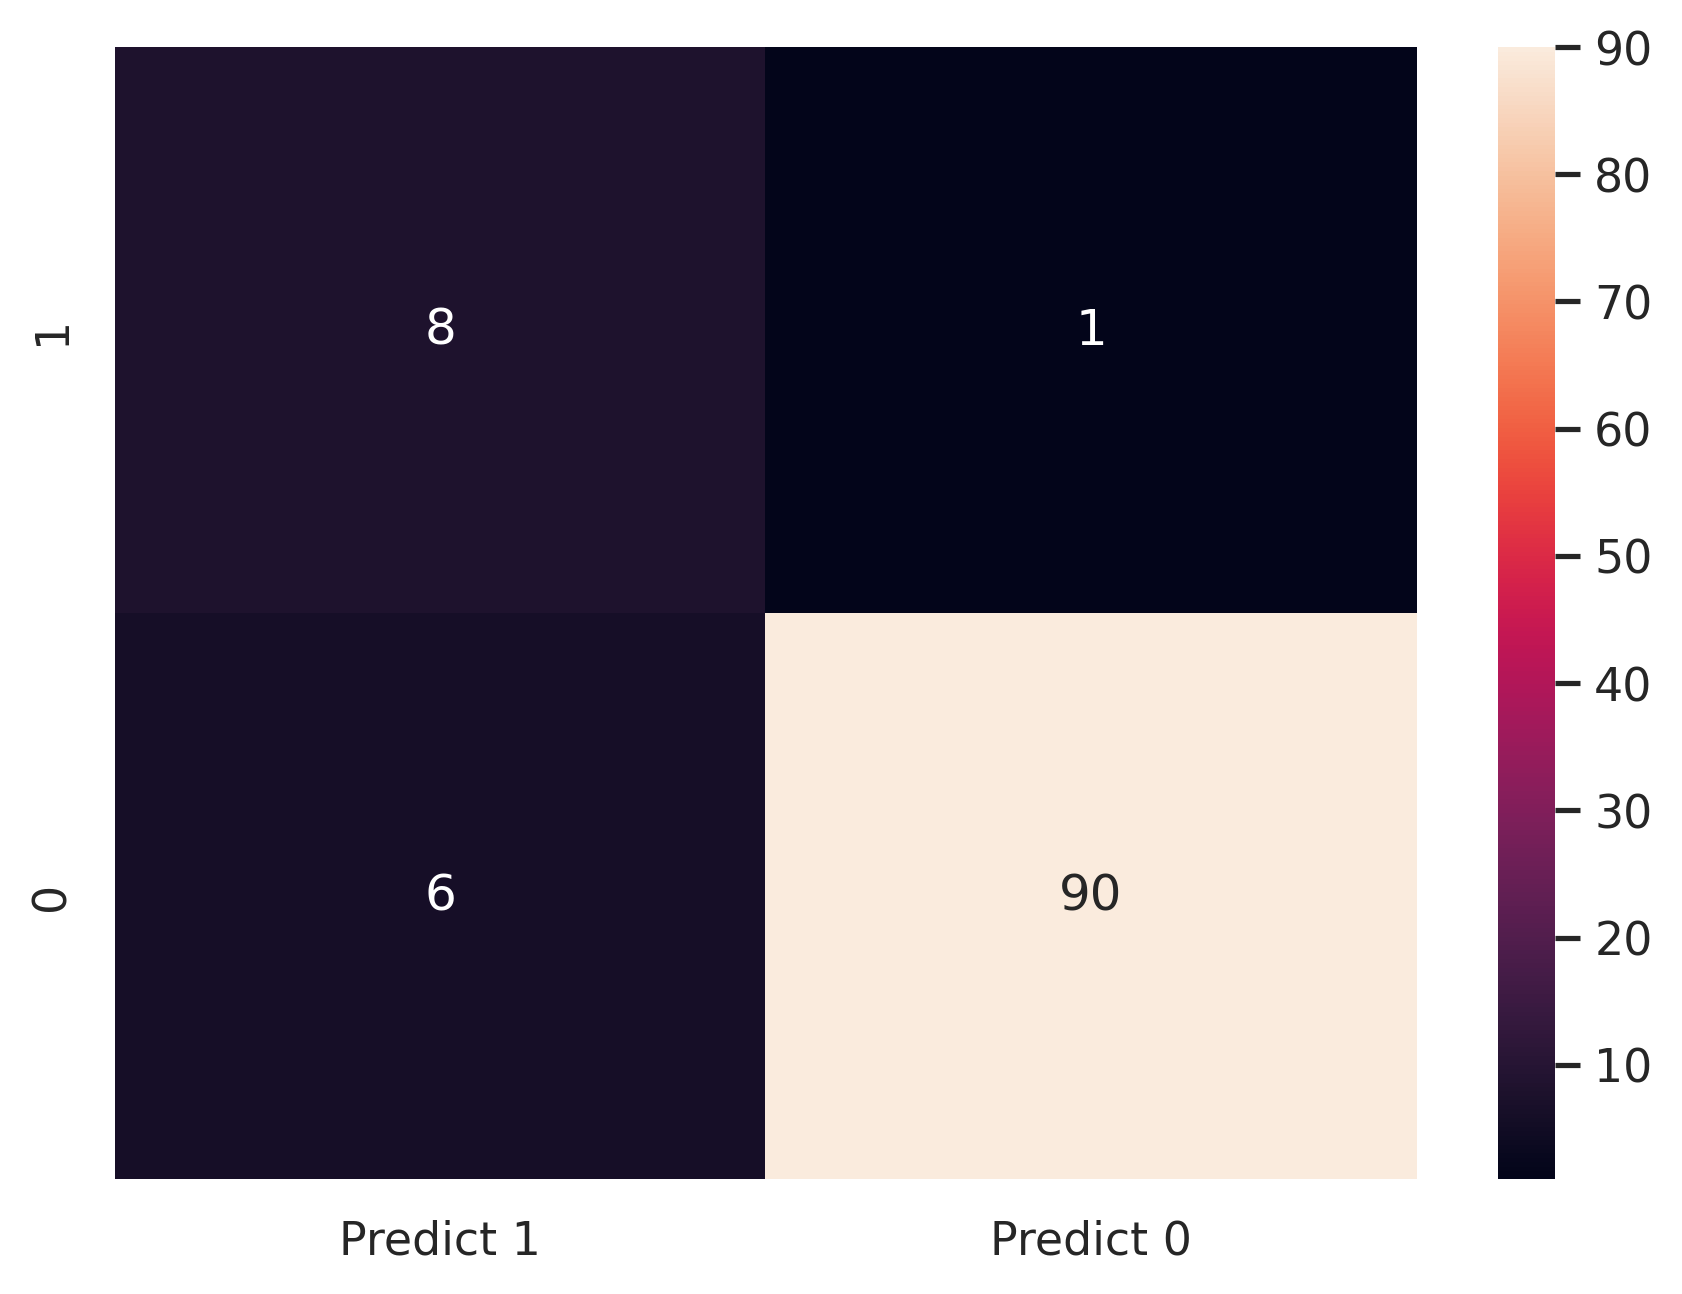

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred, labels=[1,0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                         columns = [i for i in ["Predict 1", "Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt='g')

# **Ensemble learning - AdaBoosting**

In [ ]:
def ada_grid_search(X, y):
    #create a dictionary of all values we want to test
    param_grid = {'n_estimators':[10, 50, 100, 500], 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0]}
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    # AdaBoost model
    ada = AdaBoostClassifier()
    
    # Use gridsearch to test all values
    ada_gscv = GridSearchCV(ada, param_grid, n_jobs=-1, cv=cv, scoring='accuracy')
    #fit model to data
    grid_result = ada_gscv.fit(X, y)
    
    return grid_result.best_score_, ada_gscv.best_params_

In [ ]:
ada_grid_search(X_train_smenn, y_train_smenn)

(1.0, {'learning_rate': 0.0001, 'n_estimators': 10})

In [ ]:
abcl = AdaBoostClassifier(n_estimators=500, learning_rate=1.0)
abcl = abcl.fit(X_train_smenn, y_train_smenn)
y_pred4 = abcl.predict(X_test)

print(classification_report(y_test, y_pred4))

print("Accuracy:",metrics.accuracy_score(y_test, y_pred4))
print("Precision:",metrics.precision_score(y_test, y_pred4))
print("Recall:",metrics.recall_score(y_test, y_pred4))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        96
           1       1.00      1.00      1.00         9

    accuracy                           1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


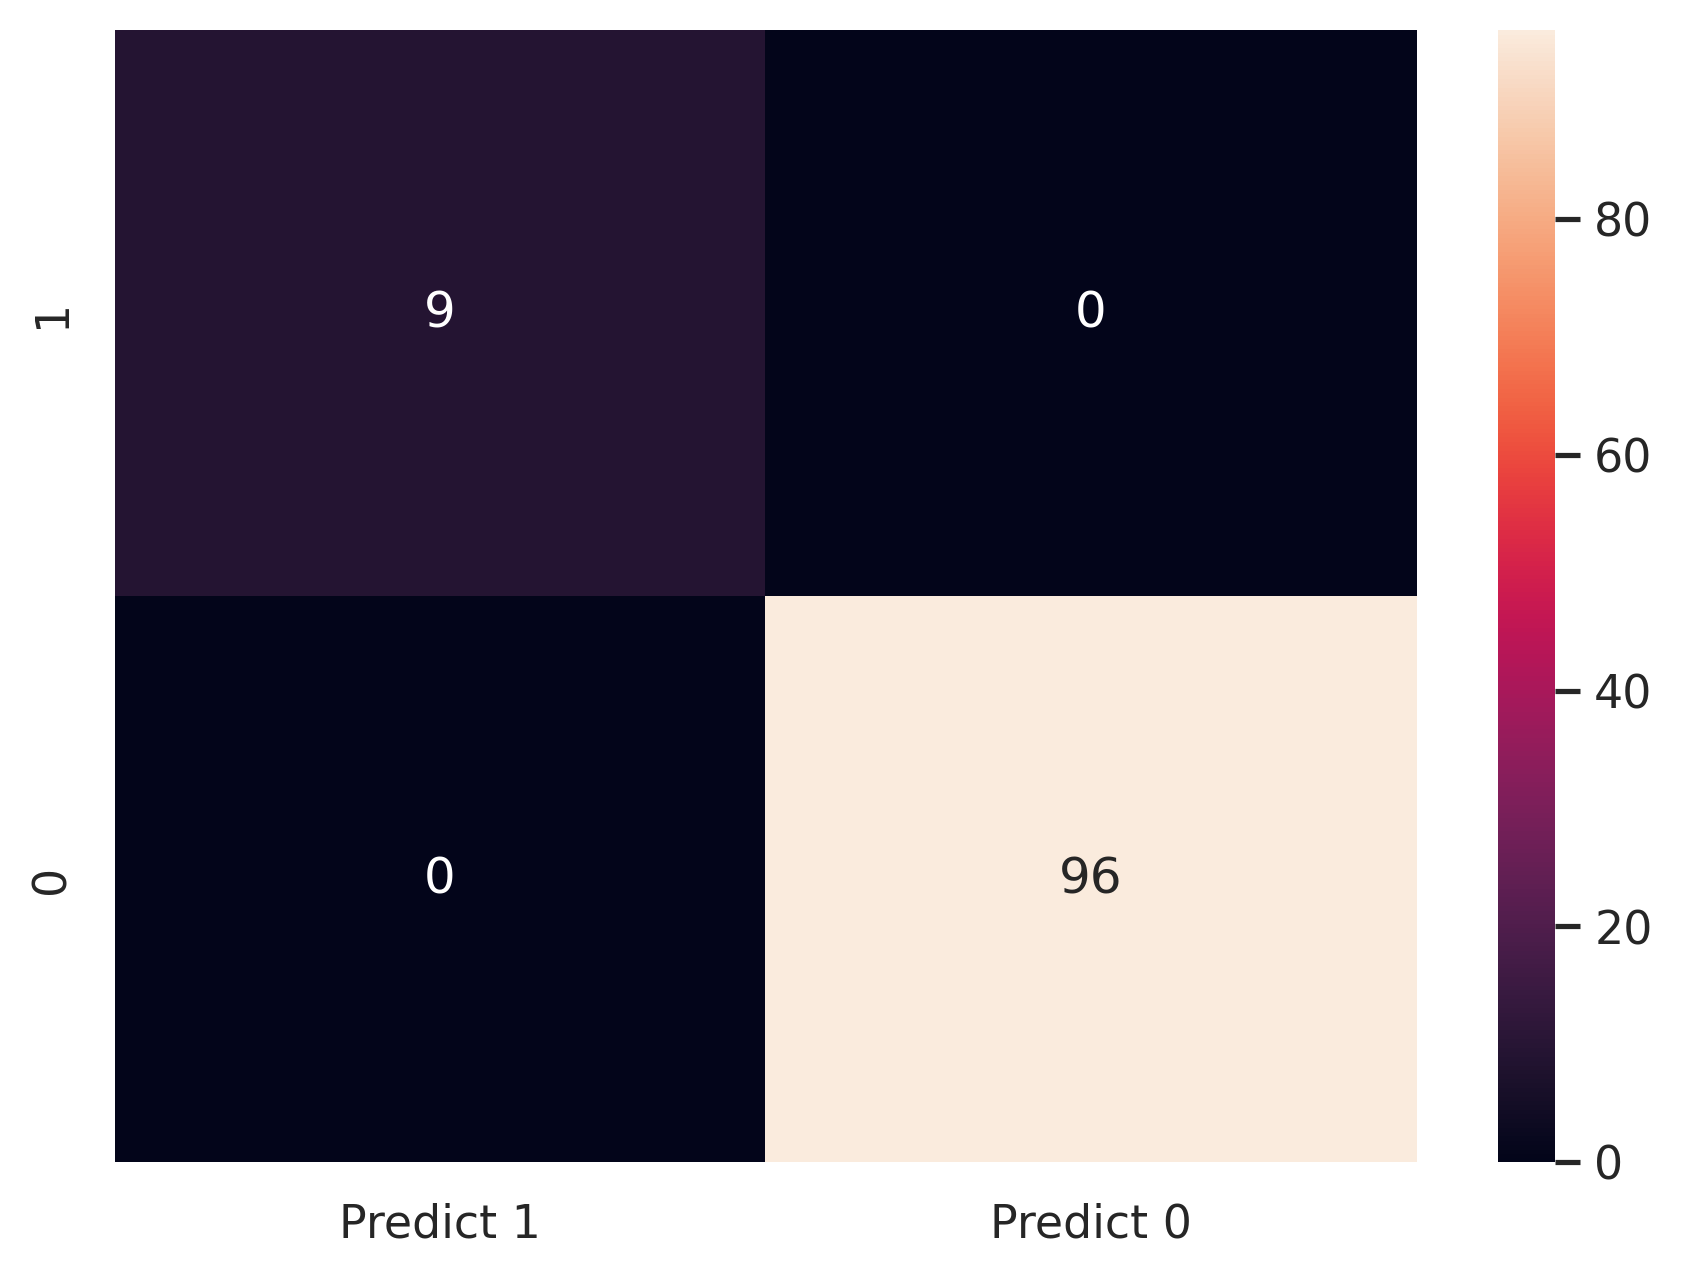

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred4, labels=[1,0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                         columns = [i for i in ["Predict 1", "Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt='g')

#**XGBoost**

In [ ]:
def xgb_grid_search(X, y):
    # Create a dictionary of all values we want to test
    param_grid = {
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    xgb = XGBClassifier()
    
    #use gridsearch to test all values
    xgb_gscv =  RandomizedSearchCV(estimator = xgb,
                           param_distributions = param_grid,
                           scoring = 'accuracy',
                           cv = cv,
                           n_jobs = -1)
    #fit model to data
    xgb_gscv.fit(X, y)
    
    return xgb_gscv.best_params_

In [ ]:
xgb_grid_search(X_train_smenn, y_train_smenn)

{'min_child_weight': 5,
 'max_depth': 4,
 'learning_rate': 0.25,
 'gamma': 0.2,
 'colsample_bytree': 0.7}

In [ ]:
xgb = XGBClassifier(min_child_weight=1, max_depth=12, learning_rate=0.2, gamma=0.0, colsample_bytree=0.3)
xgb.fit(X_train_smenn, y_train_smenn)

y_pred_xgb = xgb.predict(X_test)

print(classification_report(y_test, y_pred_xgb))

print("Accuracy:",metrics.accuracy_score(y_test, y_pred_xgb))
print("Precision:",metrics.precision_score(y_test, y_pred_xgb))
print("Recall:",metrics.recall_score(y_test, y_pred_xgb))

print(xgb.score(X_train_smenn, y_train_smenn))
print(xgb.score(X_train_smenn, y_train_smenn))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        96
           1       0.82      1.00      0.90         9

    accuracy                           0.98       105
   macro avg       0.91      0.99      0.94       105
weighted avg       0.98      0.98      0.98       105

Accuracy: 0.9809523809523809
Precision: 0.8181818181818182
Recall: 1.0
1.0
1.0


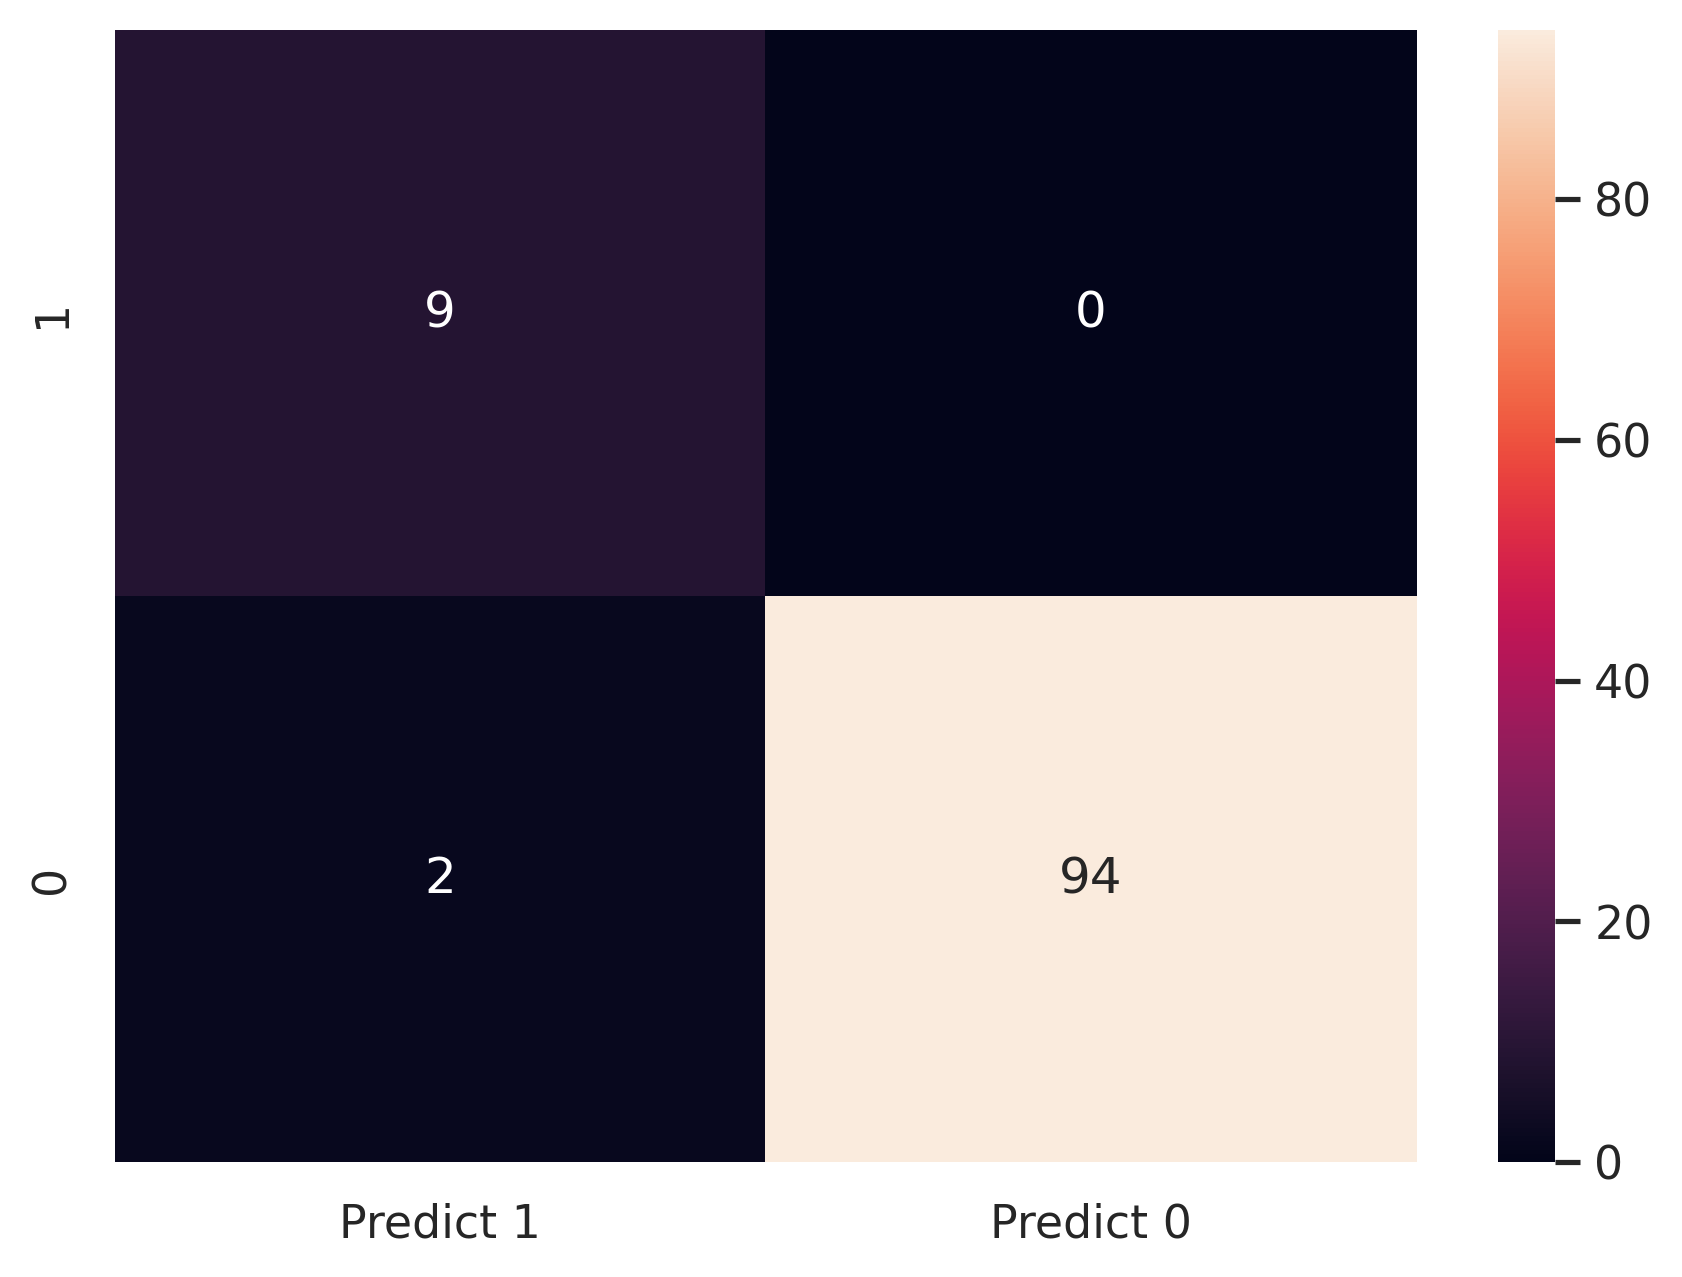

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred_xgb, labels=[1,0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                         columns = [i for i in ["Predict 1", "Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt='g')